In [4]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, AutoModelForImageClassification


C:\Users\paava\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Define categories
categories = ['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset = datasets.ImageFolder(root=r'C:\Users\paava\Desktop\Academics\Projects\Ml Project\archive\Skin_Conditions', transform=transform)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [6]:
from torchvision.models import densenet121, DenseNet121_Weights

model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)

num_features = model.classifier.in_features
model.classifier = torch.nn.Linear(num_features, len(categories))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')
torch.save(model.state_dict(), 'skin_condition_model.pth')


Epoch 1, Loss: 0.7290, Accuracy: 85.39%
Epoch 2, Loss: 0.3751, Accuracy: 88.73%
Epoch 2, Loss: 0.3751, Accuracy: 88.73%
Epoch 3, Loss: 0.2831, Accuracy: 73.49%
Epoch 3, Loss: 0.2831, Accuracy: 73.49%
Epoch 4, Loss: 0.3083, Accuracy: 83.92%
Epoch 4, Loss: 0.3083, Accuracy: 83.92%
Epoch 5, Loss: 0.2265, Accuracy: 88.31%
Epoch 5, Loss: 0.2265, Accuracy: 88.31%
Epoch 6, Loss: 0.1521, Accuracy: 91.86%
Epoch 6, Loss: 0.1521, Accuracy: 91.86%
Epoch 7, Loss: 0.1077, Accuracy: 86.43%
Epoch 7, Loss: 0.1077, Accuracy: 86.43%
Epoch 8, Loss: 0.0862, Accuracy: 93.74%
Epoch 8, Loss: 0.0862, Accuracy: 93.74%
Epoch 9, Loss: 0.1005, Accuracy: 92.69%
Epoch 9, Loss: 0.1005, Accuracy: 92.69%
Epoch 10, Loss: 0.1312, Accuracy: 85.39%
Epoch 10, Loss: 0.1312, Accuracy: 85.39%


In [10]:
def generate_report(image_path, model, transform, categories):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
 
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
        predicted_class = torch.argmax(probabilities).item()
    
    confidence_scores = {categories[i]: float(probabilities[i]) * 100 for i in range(len(categories))}
    
    
    report = {
        "diagnosis": categories[predicted_class],
        "confidence": confidence_scores[categories[predicted_class]],
        "all_probabilities": confidence_scores,
        "description": get_condition_description(categories[predicted_class]),
        "recommendations": get_recommendations(categories[predicted_class])
    }
    
    return report

def get_condition_description(condition):
    descriptions = {
        'Acne': "Inflammatory condition of the skin characterized by pimples, especially on the face, chest, and back.",
        'Carcinoma': "A type of skin cancer that begins in the cells that make up the outer layer of the skin.",
        'Eczema': "A condition where patches of skin become inflamed, itchy, red, cracked, and rough.",
        'Keratosis': "A growth of keratin on the skin, appearing as a rough, scaly patch.",
        'Milia': "Small, white bumps that appear on the skin when dead skin cells become trapped in small pockets near the surface.",
        'Rosacea': "A common skin condition that causes redness and visible blood vessels in your face."
    }
    return descriptions.get(condition, "No description available")

def get_recommendations(condition):
    recommendations = {
        'Acne': ["Keep skin clean", "Use non-comedogenic products", "Consider topical treatments with benzoyl peroxide or salicylic acid", "Consult a dermatologist for severe cases"],
        'Carcinoma': ["Seek immediate medical attention", "Protect skin from sun exposure", "Regular skin checks", "Follow up with a dermatologist or oncologist"],
        'Eczema': ["Moisturize regularly", "Avoid triggers like harsh soaps", "Use prescribed topical corticosteroids", "Consider antihistamines for itching"],
        'Keratosis': ["Protect skin from sun", "Moisturize regularly", "Consult dermatologist for removal options", "Monitor for changes"],
        'Milia': ["Do not attempt to extract them yourself", "Use exfoliating products", "Consult a dermatologist for extraction", "Use retinoids as prescribed"],
        'Rosacea': ["Avoid triggers like spicy food and alcohol", "Use gentle skin care products", "Protect from sun exposure", "Consider prescribed medications"]
    }
    return recommendations.get(condition, ["Consult a healthcare professional for proper diagnosis and treatment"])


In [11]:
def analyze_skin_condition(image_path):
    # Load the trained model
    model = densenet121(num_classes=len(categories))
    model.load_state_dict(torch.load('skin_condition_model.pth'))
    model = model.to(device)
    report = generate_report(image_path, model, transform, categories)
    print(f"Diagnosis: {report['diagnosis']} (Confidence: {report['confidence']:.2f}%)")
    print("\nDescription:")
    print(report['description'])
    print("\nRecommendations:")
    for rec in report['recommendations']:
        print(f"- {rec}")
    print("\nAll probabilities:")
    for condition, prob in report['all_probabilities'].items():
        print(f"- {condition}: {prob:.2f}%")
    
    
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Diagnosed as: {report['diagnosis']}")
    plt.axis('off')
    plt.show()
    
    return report


C:\Users\paava\AppData\Local\Temp\ipykernel_14076\200274652.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('skin_condition_model.pth'))

Diagnosis: Carcinoma (Confidence: 99.97%)

Description:
A type of skin cancer that begins in the cells that make up the outer layer of the skin.

Recommendations:
- Seek immediate medical attention
- Protect skin from sun exposure
- Regular skin checks
- Follow up with a dermatologist or oncologist

All probabilities:
- Acne: 0.03%
- Carcinoma: 99.97%
- Eczema: 0.00%
- Keratosis: 0.00%
- Milia: 0.00%
- Rosacea: 0.00%


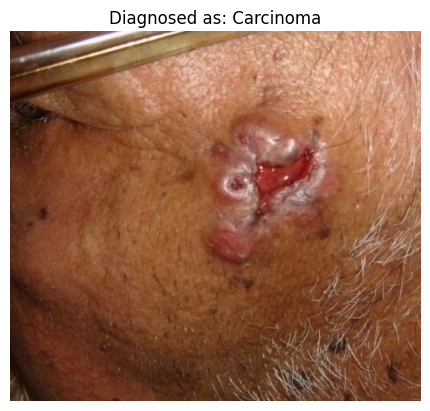

In [12]:
from PIL import Image  # Add this import statement

# Example usage
image_path = r"archive\Skin_Conditions\Carcinoma\Carcinoma_351.jpg"  # Replace with your actual image path
report = analyze_skin_condition(image_path)

Epoch 1, Loss: 0.1437, Accuracy: 89.77%
Epoch 2, Loss: 0.0646, Accuracy: 93.11%
Epoch 3, Loss: 0.0848, Accuracy: 91.02%
Epoch 4, Loss: 0.0573, Accuracy: 92.28%
Epoch 5, Loss: 0.0403, Accuracy: 94.36%
Epoch 6, Loss: 0.0407, Accuracy: 93.95%
Epoch 7, Loss: 0.0722, Accuracy: 91.65%
Epoch 8, Loss: 0.0775, Accuracy: 87.68%
Epoch 9, Loss: 0.1568, Accuracy: 88.73%
Epoch 10, Loss: 0.0984, Accuracy: 93.11%


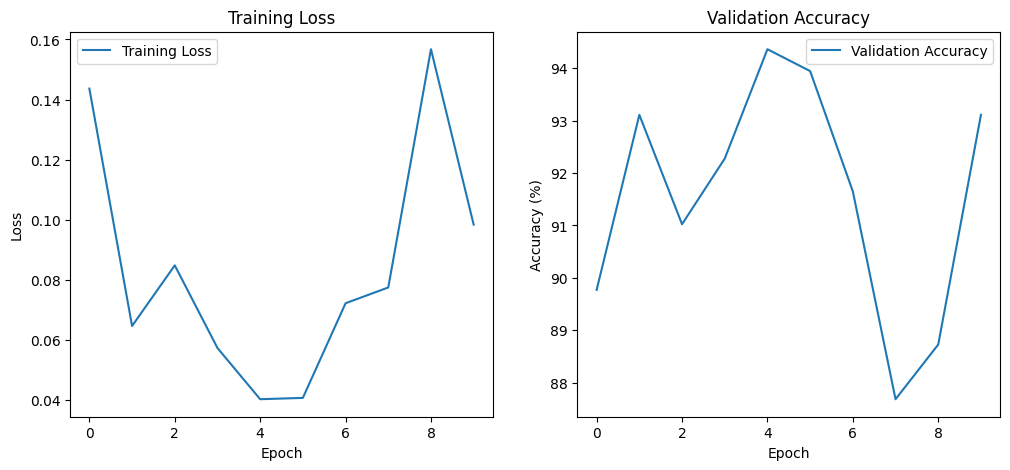

In [13]:
import matplotlib.pyplot as plt

# Lists to store metrics
train_losses = []
val_accuracies = []

# Training loop (modified to store metrics)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))  # Store training loss

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy) # Store validation accuracy
    print(f'Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}, Accuracy: {val_accuracy:.2f}%')

torch.save(model.state_dict(), 'skin_condition_model.pth')

# Plotting the training loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plotting the validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

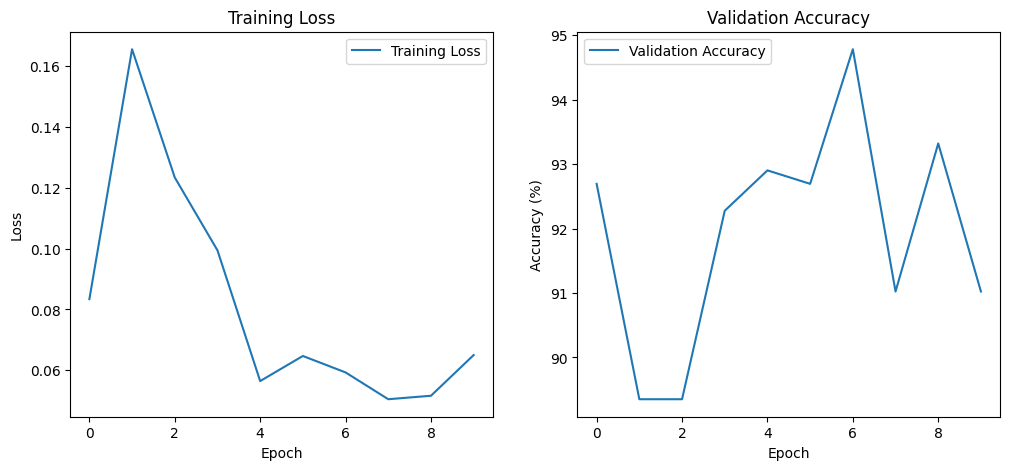

In [10]:
# Plotting the training loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.savefig('training_loss.png') #saves the image

# Plotting the validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.savefig('validation_accuracy.png') #saves the image
plt.show()


In [14]:
# K-Fold Cross Validation Implementation
from sklearn.model_selection import KFold
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
from torchvision import transforms, datasets

# Define transform for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.ImageFolder(root=r'C:\Users\paava\Desktop\Academics\Projects\Ml Project\archive\Skin_Conditions', transform=transform)

# Define categories based on dataset classes
categories = [c for c in dataset.classes]
print(f"Dataset classes: {categories}")

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_train_losses = []
fold_val_accuracies = []

for fold, (train_ids, val_ids) in enumerate(kf.split(range(len(dataset)))):
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    
    train_loader = DataLoader(dataset, batch_size=32, sampler=train_subsampler)
    val_loader = DataLoader(dataset, batch_size=32, sampler=val_subsampler)
    
    model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
    model.classifier = torch.nn.Linear(model.classifier.in_features, len(categories))
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    val_accuracies = []
    
    for epoch in range(10):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        print(f'Fold {fold+1}, Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {val_accuracy:.2f}%')
    
    fold_train_losses.append(train_losses)
    fold_val_accuracies.append(val_accuracies)

avg_train_losses = np.mean(fold_train_losses, axis=0)
avg_val_accuracies = np.mean(fold_val_accuracies, axis=0)

print(f"Average final accuracy across folds: {avg_val_accuracies[-1]:.2f}%")

Dataset classes: ['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']
Fold 1, Epoch 1, Loss: 0.6899, Accuracy: 77.45%
Fold 1, Epoch 1, Loss: 0.6899, Accuracy: 77.45%
Fold 1, Epoch 2, Loss: 0.3620, Accuracy: 73.49%
Fold 1, Epoch 2, Loss: 0.3620, Accuracy: 73.49%
Fold 1, Epoch 3, Loss: 0.2764, Accuracy: 80.58%
Fold 1, Epoch 3, Loss: 0.2764, Accuracy: 80.58%
Fold 1, Epoch 4, Loss: 0.2502, Accuracy: 89.14%
Fold 1, Epoch 4, Loss: 0.2502, Accuracy: 89.14%
Fold 1, Epoch 5, Loss: 0.1570, Accuracy: 91.86%
Fold 1, Epoch 5, Loss: 0.1570, Accuracy: 91.86%
Fold 1, Epoch 6, Loss: 0.1346, Accuracy: 88.10%
Fold 1, Epoch 6, Loss: 0.1346, Accuracy: 88.10%
Fold 1, Epoch 7, Loss: 0.2236, Accuracy: 85.59%
Fold 1, Epoch 7, Loss: 0.2236, Accuracy: 85.59%
Fold 1, Epoch 8, Loss: 0.1399, Accuracy: 90.40%
Fold 1, Epoch 8, Loss: 0.1399, Accuracy: 90.40%
Fold 1, Epoch 9, Loss: 0.1101, Accuracy: 85.39%
Fold 1, Epoch 9, Loss: 0.1101, Accuracy: 85.39%
Fold 1, Epoch 10, Loss: 0.0782, Accuracy: 92.28%
Fold 

In [15]:
# Stratified Split Implementation
from sklearn.model_selection import train_test_split
import torch

targets = [dataset[i][1] for i in range(len(dataset))]

train_indices, val_indices = train_test_split(
    range(len(targets)), 
    test_size=0.2, 
    stratify=targets,
    random_state=42
)

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

stratified_train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
stratified_val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
model.classifier = torch.nn.Linear(model.classifier.in_features, len(categories))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in stratified_train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(stratified_train_loader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in stratified_val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(stratified_val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

torch.save(model.state_dict(), 'skin_condition_stratified.pth')

Epoch 1, Train Loss: 0.6977, Train Acc: 75.61%, Val Loss: 0.5871, Val Acc: 80.58%
Epoch 2, Train Loss: 0.3919, Train Acc: 86.16%, Val Loss: 2.7357, Val Acc: 58.04%
Epoch 2, Train Loss: 0.3919, Train Acc: 86.16%, Val Loss: 2.7357, Val Acc: 58.04%
Epoch 3, Train Loss: 0.2994, Train Acc: 88.83%, Val Loss: 0.3512, Val Acc: 88.31%
Epoch 3, Train Loss: 0.2994, Train Acc: 88.83%, Val Loss: 0.3512, Val Acc: 88.31%
Epoch 4, Train Loss: 0.2317, Train Acc: 92.17%, Val Loss: 0.3268, Val Acc: 89.98%
Epoch 4, Train Loss: 0.2317, Train Acc: 92.17%, Val Loss: 0.3268, Val Acc: 89.98%
Epoch 5, Train Loss: 0.1533, Train Acc: 94.73%, Val Loss: 0.2821, Val Acc: 90.40%
Epoch 5, Train Loss: 0.1533, Train Acc: 94.73%, Val Loss: 0.2821, Val Acc: 90.40%
Epoch 6, Train Loss: 0.1328, Train Acc: 95.56%, Val Loss: 0.3434, Val Acc: 88.10%
Epoch 6, Train Loss: 0.1328, Train Acc: 95.56%, Val Loss: 0.3434, Val Acc: 88.10%
Epoch 7, Train Loss: 0.2099, Train Acc: 92.90%, Val Loss: 0.4393, Val Acc: 88.10%
Epoch 7, Train L

In [16]:
# Stratified Split Implementation
from sklearn.model_selection import train_test_split
import torch

targets = [dataset[i][1] for i in range(len(dataset))]

train_indices, val_indices = train_test_split(
    range(len(targets)), 
    test_size=0.2, 
    stratify=targets,
    random_state=42
)

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

stratified_train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
stratified_val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
model.classifier = torch.nn.Linear(model.classifier.in_features, len(categories))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in stratified_train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(stratified_train_loader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in stratified_val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(stratified_val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

torch.save(model.state_dict(), 'skin_condition_stratified.pth')

Epoch 1, Train Loss: 0.7047, Train Acc: 75.04%, Val Loss: 1.2533, Val Acc: 62.00%
Epoch 2, Train Loss: 0.4463, Train Acc: 85.74%, Val Loss: 0.4597, Val Acc: 85.18%
Epoch 2, Train Loss: 0.4463, Train Acc: 85.74%, Val Loss: 0.4597, Val Acc: 85.18%
Epoch 3, Train Loss: 0.2993, Train Acc: 89.50%, Val Loss: 0.3981, Val Acc: 88.52%
Epoch 3, Train Loss: 0.2993, Train Acc: 89.50%, Val Loss: 0.3981, Val Acc: 88.52%
Epoch 4, Train Loss: 0.1968, Train Acc: 93.21%, Val Loss: 0.2676, Val Acc: 92.28%
Epoch 4, Train Loss: 0.1968, Train Acc: 93.21%, Val Loss: 0.2676, Val Acc: 92.28%
Epoch 5, Train Loss: 0.1704, Train Acc: 94.36%, Val Loss: 0.3827, Val Acc: 87.27%
Epoch 5, Train Loss: 0.1704, Train Acc: 94.36%, Val Loss: 0.3827, Val Acc: 87.27%
Epoch 6, Train Loss: 0.1615, Train Acc: 94.20%, Val Loss: 0.3103, Val Acc: 91.44%
Epoch 6, Train Loss: 0.1615, Train Acc: 94.20%, Val Loss: 0.3103, Val Acc: 91.44%
Epoch 7, Train Loss: 0.1336, Train Acc: 95.82%, Val Loss: 0.2985, Val Acc: 91.86%
Epoch 7, Train L

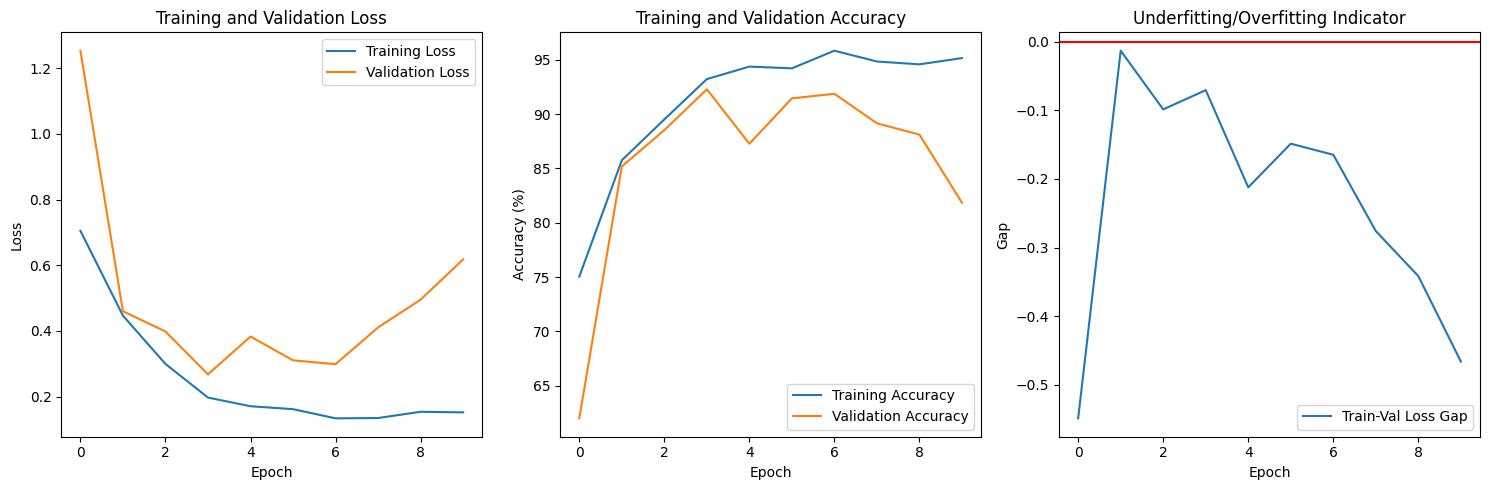

Model is properly fitted


In [17]:
# Underfitting Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
loss_gap = [train_losses[i] - val_losses[i] for i in range(len(train_losses))]
plt.plot(range(len(train_losses)), loss_gap, label='Train-Val Loss Gap')
plt.xlabel('Epoch')
plt.ylabel('Gap')
plt.title('Underfitting/Overfitting Indicator')
plt.axhline(y=0, color='r', linestyle='-')
plt.legend()
plt.tight_layout()
plt.savefig('model_fitting_analysis.png')
plt.show()

if train_losses[-1] > 0.5 and abs(train_losses[-1] - val_losses[-1]) < 0.1:
    print("Model is underfitting - high error on both training and validation sets")
elif train_losses[-1] < 0.1 and val_losses[-1] > 0.5:
    print("Model is overfitting - low training error but high validation error")
else:
    print("Model is properly fitted")

In [18]:
from sklearn.model_selection import train_test_split
indices=list(range(len(dataset)))
train_idx,val_idx=train_test_split(indices,test_size=0.2,random_state=42)
train_loader=DataLoader(dataset,batch_size=32,sampler=torch.utils.data.SubsetRandomSampler(train_idx))
val_loader=DataLoader(dataset,batch_size=32,sampler=torch.utils.data.SubsetRandomSampler(val_idx))
model=densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
model.classifier=torch.nn.Linear(model.classifier.in_features,len(categories))
model=model.to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
criterion=torch.nn.CrossEntropyLoss()
train_losses=[]
val_losses=[]
for epoch in range(5):
    running_loss=0
    model.train()
    for x,y in train_loader:
        x,y=x.to(device),y.to(device)
        optimizer.zero_grad()
        out=model(x)
        loss=criterion(out,y)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    train_losses.append(running_loss/len(train_loader))
    correct=0;total=0
    model.eval()
    with torch.no_grad():
        for x,y in val_loader:
            x,y=x.to(device),y.to(device)
            out=model(x)
            _,p=torch.max(out,1)
            total+=y.size(0)
            correct+=(p==y).sum().item()
    val_losses.append(1-(correct/total))
print(train_losses,val_losses)

[0.7031124571959178, 0.3520805443326632, 0.2993833183000485, 0.26779397347321116, 0.22354268860071896] [0.17118997912317324, 0.2317327766179541, 0.1878914405010439, 0.1503131524008351, 0.12317327766179542]


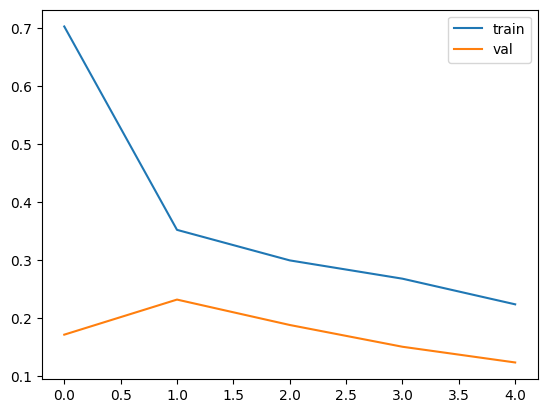

In [19]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train')
plt.plot(val_losses,label='val')
plt.legend()
plt.show()
if train_losses[-1]>0.5 and val_losses[-1]>0.5:
    print('underfitting')

In [20]:
from sklearn.svm import SVC
import numpy as np
features=[]
labels=[]
with torch.no_grad():
    for x,y in train_loader:
        feats=model.features(x.to(device)).cpu().numpy().reshape(x.size(0),-1)
        features.append(feats)
        labels.append(y.numpy())
X_train=np.vstack(features)
y_train=np.hstack(labels)
svm=SVC()
svm.fit(X_train,y_train)
features=[]
labels=[]
with torch.no_grad():
    for x,y in val_loader:
        feats=model.features(x.to(device)).cpu().numpy().reshape(x.size(0),-1)
        features.append(feats)
        labels.append(y.numpy())
X_val=np.vstack(features)
y_val=np.hstack(labels)
acc=svm.score(X_val,y_val)
print(acc)

0.9248434237995825


<>:19: SyntaxWarning: invalid escape sequence '\S'
<>:19: SyntaxWarning: invalid escape sequence '\S'
C:\Users\paava\AppData\Local\Temp\ipykernel_3840\1352051365.py:19: SyntaxWarning: invalid escape sequence '\S'
  dataset_path = "archive\Skin_Conditions"


Loading and extracting features from images...
Processing Acne images...
Processing Carcinoma images...
Processing Carcinoma images...
Processing Eczema images...
Processing Eczema images...
Processing Keratosis images...
Processing Keratosis images...
Processing Milia images...
Processing Milia images...
Processing Rosacea images...
Processing Rosacea images...
Dataset loaded: 2394 images with 18 features per image
Training set: 1915 images
Testing set: 479 images
Reduced features from 18 to 18

Training Decision Tree...
Dataset loaded: 2394 images with 18 features per image
Training set: 1915 images
Testing set: 479 images
Reduced features from 18 to 18

Training Decision Tree...


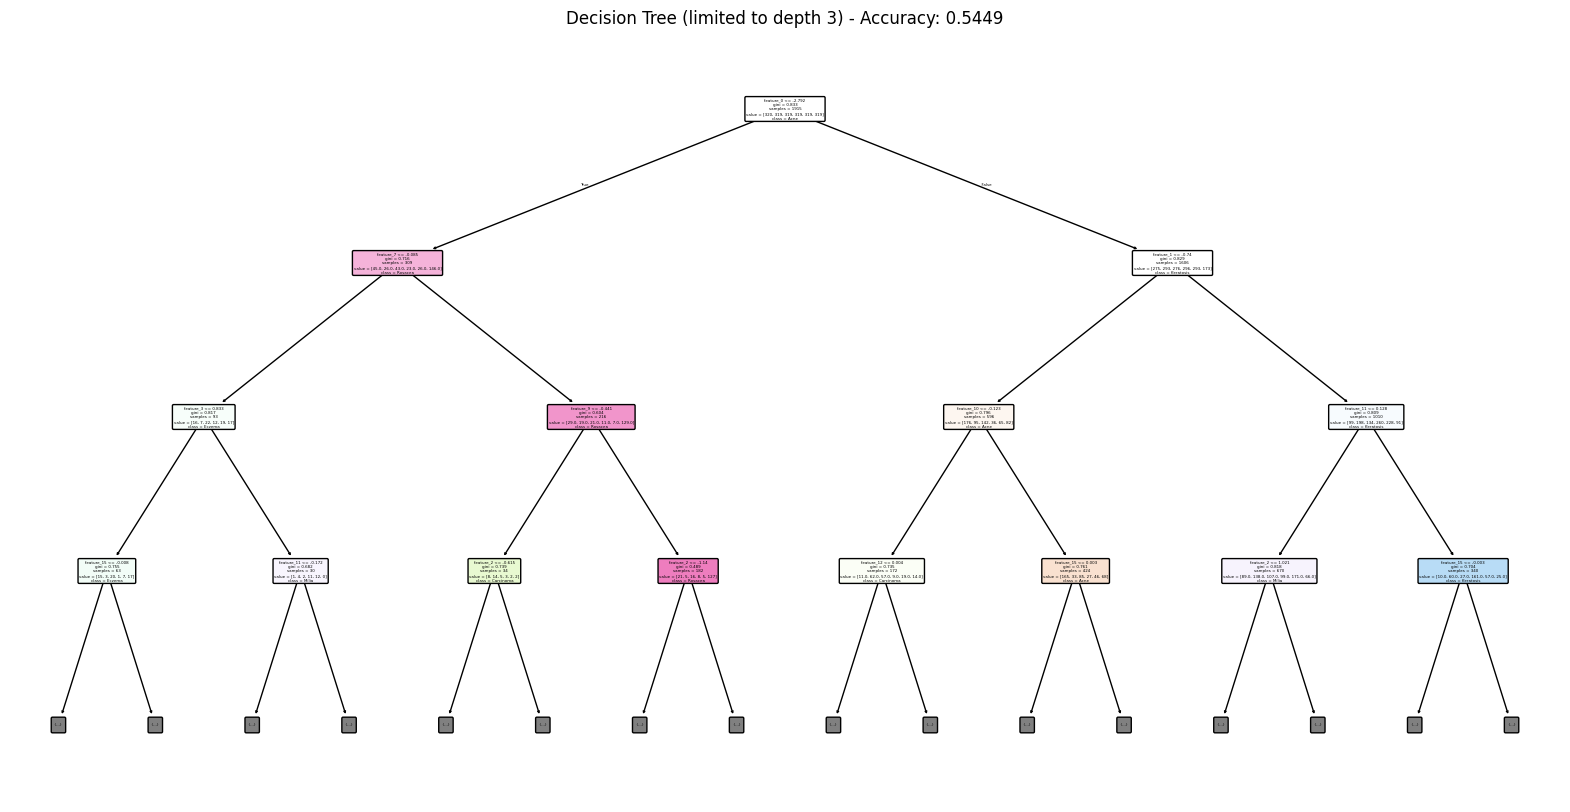

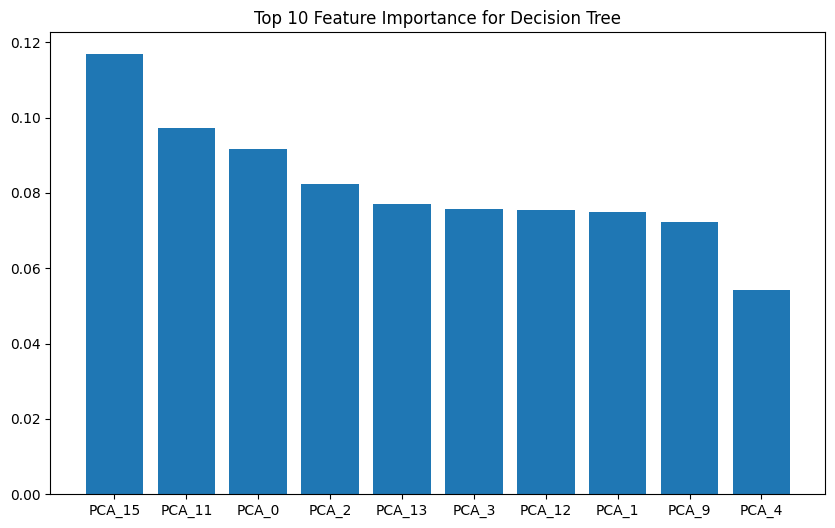

Decision Tree Results:
Accuracy: 0.5449
Precision: 0.5586
Recall: 0.5449
F1 Score: 0.5416
ROC AUC: 0.8112

Classification Report for Decision Tree:
              precision    recall  f1-score   support

        Acne       0.53      0.52      0.53        79
   Carcinoma       0.57      0.64      0.60        80
      Eczema       0.53      0.39      0.45        80
   Keratosis       0.61      0.64      0.63        80
       Milia       0.45      0.66      0.53        80
     Rosacea       0.67      0.42      0.52        80

    accuracy                           0.54       479
   macro avg       0.56      0.54      0.54       479
weighted avg       0.56      0.54      0.54       479



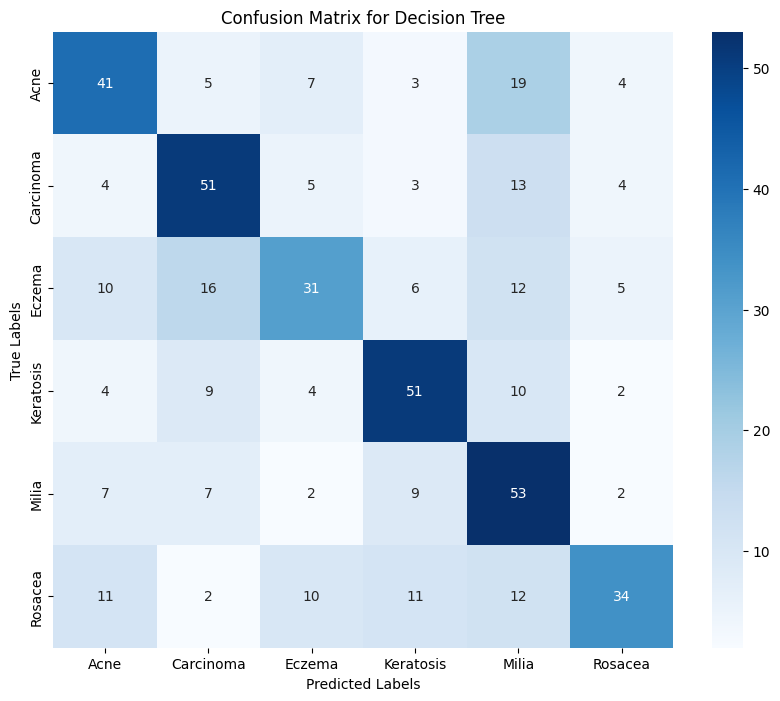


Training Random Forest...
Random Forest Results:
Accuracy: 0.7912
Precision: 0.7913
Recall: 0.7912
F1 Score: 0.7875
ROC AUC: 0.9474

Training SVM...
Random Forest Results:
Accuracy: 0.7912
Precision: 0.7913
Recall: 0.7912
F1 Score: 0.7875
ROC AUC: 0.9474

Training SVM...
SVM Results:
Accuracy: 0.6472
Precision: 0.6617
Recall: 0.6472
F1 Score: 0.6464
ROC AUC: 0.8971

Training KNN...
SVM Results:
Accuracy: 0.6472
Precision: 0.6617
Recall: 0.6472
F1 Score: 0.6464
ROC AUC: 0.8971

Training KNN...
KNN Results:
Accuracy: 0.5511
Precision: 0.5623
Recall: 0.5511
F1 Score: 0.5483
ROC AUC: 0.8457

Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.4864
Precision: 0.4847
Recall: 0.4864
F1 Score: 0.4817
ROC AUC: 0.8164

Training Gradient Boosting...
KNN Results:
Accuracy: 0.5511
Precision: 0.5623
Recall: 0.5511
F1 Score: 0.5483
ROC AUC: 0.8457

Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.4864
Precision: 0.4847
Recall: 0.4864
F1 Score: 0.4817
ROC 

C:\Users\paava\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Gradient Boosting Results:
Accuracy: 0.7265
Precision: 0.7322
Recall: 0.7265
F1 Score: 0.7256
ROC AUC: 0.9241

Model Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score
0        Decision Tree  0.544885   0.558564  0.544885  0.541566
1        Random Forest  0.791232   0.791274  0.791232  0.787509
2                  SVM  0.647182   0.661732  0.647182  0.646420
3                  KNN  0.551148   0.562286  0.551148  0.548299
4  Logistic Regression  0.486430   0.484748  0.486430  0.481691
5    Gradient Boosting  0.726514   0.732218  0.726514  0.725625


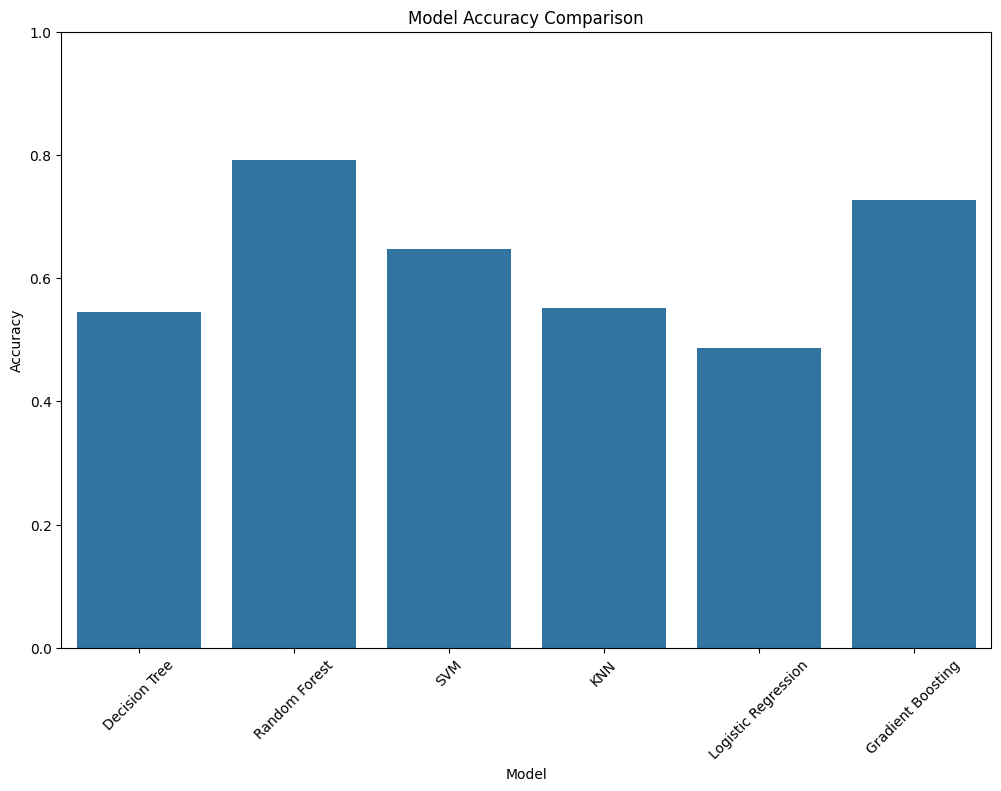

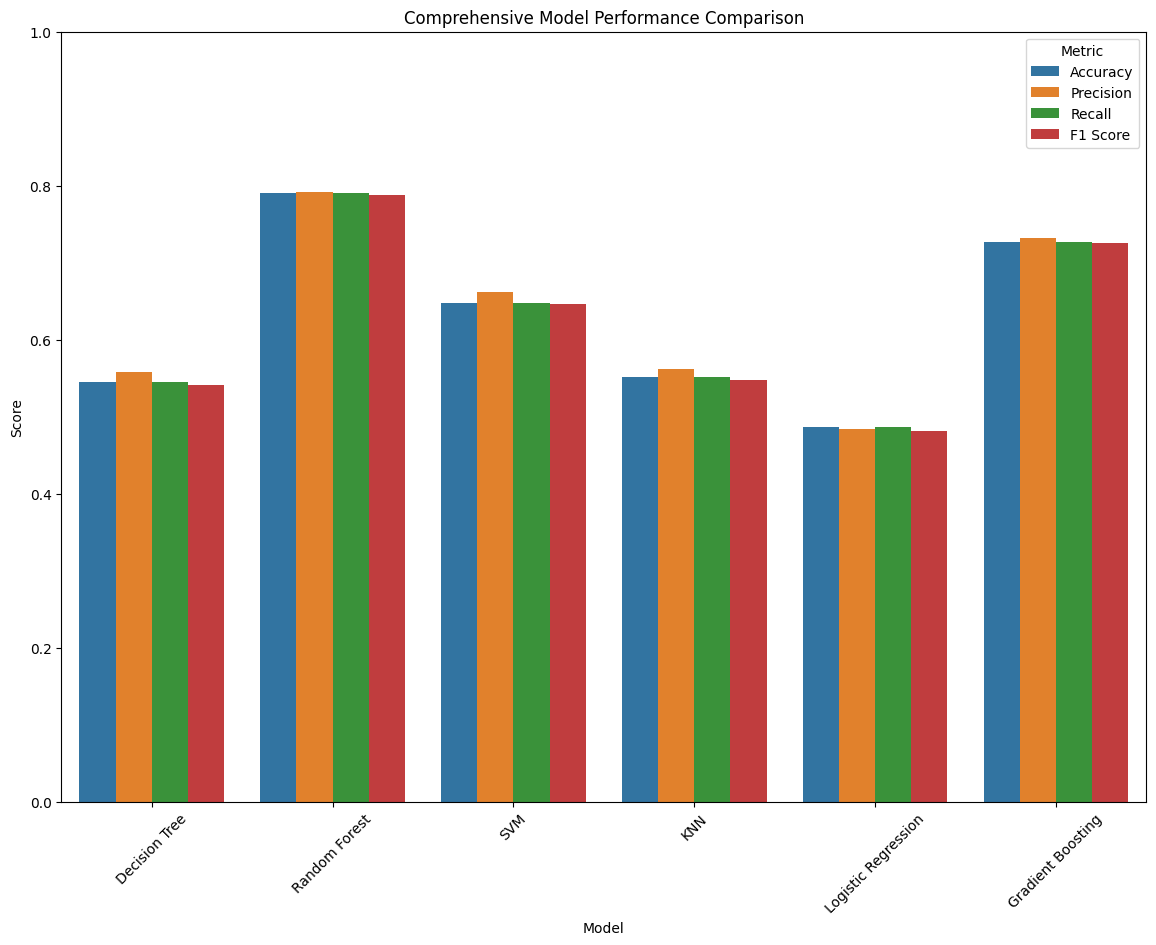


Predicting sample image with Decision Tree:
Predicted class: Eczema
Probabilities:
  Acne: 0.1429
  Carcinoma: 0.1429
  Eczema: 0.4286
  Keratosis: 0.0000
  Milia: 0.0000
  Rosacea: 0.2857


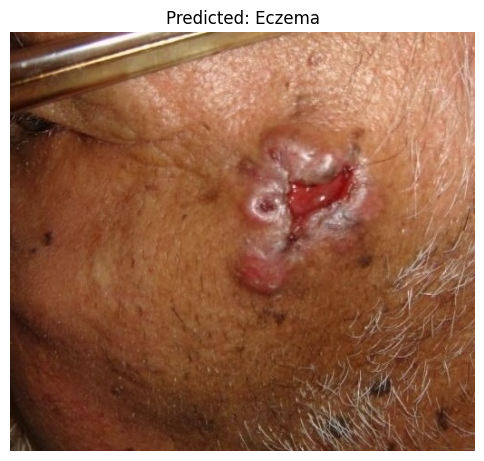

Models and transformers saved


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import cv2
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

dataset_path = "archive\Skin_Conditions"

categories = ['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']

def extract_features(image_path, size=(64, 64)):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img = cv2.resize(img, size)
    
    features = []
    
    for i in range(3):
        features.append(np.mean(img[:,:,i]))
        features.append(np.std(img[:,:,i]))
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    hist = cv2.calcHist([gray], [0], None, [8], [0, 256])
    hist = hist.flatten() / np.sum(hist)
    features.extend(hist)
    
    edges = cv2.Canny(gray, 100, 200)
    features.append(np.mean(edges))
    features.append(np.std(edges))
    
    features.append(np.mean(gray))
    features.append(np.std(gray))
    
    return features

def load_dataset(dataset_path):
    features = []
    labels = []
    image_paths = []
    
    print("Loading and extracting features from images...")
    
    for i, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        print(f"Processing {category} images...")
        
        files = os.listdir(category_path)
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(category_path, file)
                image_features = extract_features(image_path)
                
                if image_features is not None:
                    features.append(image_features)
                    labels.append(i)
                    image_paths.append(image_path)
    
    return np.array(features), np.array(labels), image_paths

X, y, image_paths = load_dataset(dataset_path)
print(f"Dataset loaded: {X.shape[0]} images with {X.shape[1]} features per image")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} images")
print(f"Testing set: {X_test.shape[0]} images")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=min(20, X_train_scaled.shape[1]))
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"Reduced features from {X_train_scaled.shape[1]} to {X_train_pca.shape[1]}")

classifiers = {
    "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5, min_samples_leaf=2, random_state=42),
    "SVM": SVC(kernel='rbf', C=10, probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = {}

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train_pca, y_train)
    
    y_pred = clf.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    
    if name == "Decision Tree":
        dt_classifier = clf
        dt_accuracy = accuracy
        
        plt.figure(figsize=(20, 10))
        plot_tree(dt_classifier, filled=True, feature_names=[f"feature_{i}" for i in range(X_train_pca.shape[1])], 
                class_names=categories, rounded=True, max_depth=3)
        plt.title(f"Decision Tree (limited to depth 3) - Accuracy: {accuracy:.4f}")
        plt.savefig('decision_tree_visualization.png')
        plt.show()
        
        feature_importance = dt_classifier.feature_importances_
        top_features = np.argsort(feature_importance)[::-1][:10]
        plt.figure(figsize=(10, 6))
        plt.bar(range(10), feature_importance[top_features])
        plt.xticks(range(10), [f"PCA_{i}" for i in top_features])
        plt.title("Top 10 Feature Importance for Decision Tree")
        plt.savefig('feature_importance.png')
        plt.show()
        
    if hasattr(clf, "predict_proba"):
        y_prob = clf.predict_proba(X_test_pca)
        roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    else:
        roc_auc = None
    
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
    
    results[name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    }
    
    if name == "Decision Tree":
        print("\nClassification Report for Decision Tree:")
        print(classification_report(y_test, y_pred, target_names=categories))
        
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix for Decision Tree')
        plt.savefig('decision_tree_confusion_matrix.png')
        plt.show()

comparison_data = []
for name, metrics in results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison:")
print(comparison_df)

plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Accuracy', data=comparison_df)
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.savefig('model_comparison_accuracy.png')
plt.show()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
comparison_melted = pd.melt(comparison_df, id_vars=['Model'], value_vars=metrics, 
                           var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 10))
sns.barplot(x='Model', y='Score', hue='Metric', data=comparison_melted)
plt.title('Comprehensive Model Performance Comparison')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.savefig('comprehensive_model_comparison.png')
plt.show()

def predict_image(image_path, model, scaler, pca):
    features = extract_features(image_path)
    if features is None:
        return None
    
    features_scaled = scaler.transform([features])
    features_pca = pca.transform(features_scaled)
    prediction = model.predict(features_pca)[0]
    probabilities = model.predict_proba(features_pca)[0]
    
    return {
        "class": categories[prediction],
        "probabilities": {categories[i]: prob for i, prob in enumerate(probabilities)}
    }

sample_image_path = os.path.join(dataset_path, "Carcinoma", "Carcinoma_351.jpg")
if os.path.exists(sample_image_path):
    print("\nPredicting sample image with Decision Tree:")
    result = predict_image(sample_image_path, dt_classifier, scaler, pca)
    if result:
        print(f"Predicted class: {result['class']}")
        print("Probabilities:")
        for cls, prob in result['probabilities'].items():
            print(f"  {cls}: {prob:.4f}")
        
        img = Image.open(sample_image_path)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Predicted: {result['class']}")
        plt.axis('off')
        plt.show()
else:
    print(f"Sample image not found: {sample_image_path}")

import joblib
joblib.dump(dt_classifier, 'decision_tree_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(pca, 'pca_transformer.pkl')
print("Models and transformers saved")